In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from CustomDatasets import SingleMagnetDataset
from Unet_MaxProkop import UNet
import functions

##### Load up dataset

In [4]:
if os.path.exists("../../Stage_magnet"):
    new_magnet_folder = "../../Stage_magnet_cached"
else:
    new_magnet_folder = "../Stage_magnet_cached"
val_set = SingleMagnetDataset(new_magnet_folder, (0.80,0.81),maximum_elements=20480)
val_loader = DataLoader(val_set,1)
print(val_set[0][0].shape,val_set[0][1].shape, len(val_set))

(4, 120, 80) (2, 120, 80) 203


##### Load up Model 

In [5]:
model = UNet(in_channels=4,out_channels=2,depth=4)

if torch.cuda.is_available():
    device = 'cuda'
elif torch.has_mps:
    device = 'mps'
else:
    device = 'cpu'
print(device)

model.load_state_dict(torch.load("last_checkpoint_cpu.pth",map_location=device))

cpu


<All keys matched successfully>

##### Forward the entire validation set

Compute Maximal and Average absolute error in x and y, also combine x,y to vector and compute maximal and average angle error and magnitude error

Several Problems: 
- In some pixels the field strength is 0 and then the angle is undefined, For these cases we can enable a filter in the evaluate function that only consideres pixels where the total field strength of the target (vector magnitude) is above some threshold
- This is not enough, if the prediction is o for some pixel that is supposed to have a vector with magnitude above the threshold, we still get 0/0. Here we say the model is completely off and assign the maximum angle of PI

For max and avg absolute error, also save index of worst and of median sample

In [20]:
def evaluate(inp,tar,use_mask,filter_threshold=0.7):
    pred = model(inp.float()).squeeze().detach()
    tar = tar.squeeze().detach()

    abs_error = torch.abs(pred-tar)

    dot = (pred * tar).sum(dim=0)
    mag_pred = torch.sqrt((pred * pred).sum(dim=0))
    mag_tar = torch.sqrt((tar * tar).sum(dim=0))
    mag_abs_error = torch.abs(mag_pred - mag_tar)

    # This minimum is due to numerical errors as acos of 1.000001 is Nan
    frac = torch.minimum(dot / (mag_pred * mag_tar),torch.ones_like(dot))

    # This nan_to_num are the cases where we predict 0 but ther should be a vector. This is treated as being maximally off
    angles = torch.nan_to_num(torch.acos(frac), nan=3.141529)

    mask = (mag_tar > filter_threshold if use_mask else torch.ones_like(inp[0,0,:,:]) == 1) 

    return [abs_error[0,:,:][mask].max(),
            abs_error[1,:,:][mask].max(),
            abs_error[0,:,:][mask].mean(),
            abs_error[1,:,:][mask].mean(),
            angles[mask].max(),
            angles[mask].mean(),
            mag_abs_error[mask].max(),
            mag_abs_error[mask].mean()
    ]


In [21]:
evaluate(torch.tensor(val_set[0][0]).unsqueeze(0),torch.tensor(val_set[0][1]),True)

[tensor(1.4304, dtype=torch.float64),
 tensor(1.0178, dtype=torch.float64),
 tensor(0.5502, dtype=torch.float64),
 tensor(0.3520, dtype=torch.float64),
 tensor(1.1417, dtype=torch.float64),
 tensor(0.2389, dtype=torch.float64),
 tensor(1.3843, dtype=torch.float64),
 tensor(0.7532, dtype=torch.float64)]

In [22]:
unfiltered = [evaluate(inp,tar,False) for(inp, tar) in val_loader]
filtered = [evaluate(inp,tar,True) for(inp, tar) in val_loader]

In [23]:
names= ["max_abs_error_x","max_abs_error_y","mean_abs_error_x","mean_abs_error_y","max_angular_error","mean_angular_error","max_abs_error_magnitude","mean_abs_error_magnitude"]
df_unfiltered = pd.DataFrame(unfiltered,columns=names)
df_filtered = pd.DataFrame(filtered,columns=names)

In [24]:
df_unfiltered.head()

,max_abs_error_x,max_abs_error_y,mean_abs_error_x,mean_abs_error_y,max_angular_error,mean_angular_error,max_abs_error_magnitude,mean_abs_error_magnitude
0,"tensor(1.4304, dtype=torch.float64)","tensor(1.0178, dtype=torch.float64)","tensor(0.0833, dtype=torch.float64)","tensor(0.0677, dtype=torch.float64)","tensor(nan, dtype=torch.float64)","tensor(nan, dtype=torch.float64)","tensor(1.3843, dtype=torch.float64)","tensor(0.1231, dtype=torch.float64)"
1,"tensor(1.1838, dtype=torch.float64)","tensor(1.3640, dtype=torch.float64)","tensor(0.0900, dtype=torch.float64)","tensor(0.0628, dtype=torch.float64)","tensor(nan, dtype=torch.float64)","tensor(nan, dtype=torch.float64)","tensor(1.3668, dtype=torch.float64)","tensor(0.1298, dtype=torch.float64)"
2,"tensor(1.4782, dtype=torch.float64)","tensor(1.0792, dtype=torch.float64)","tensor(0.0536, dtype=torch.float64)","tensor(0.0538, dtype=torch.float64)","tensor(nan, dtype=torch.float64)","tensor(nan, dtype=torch.float64)","tensor(1.4639, dtype=torch.float64)","tensor(0.0878, dtype=torch.float64)"
3,"tensor(1.2139, dtype=torch.float64)","tensor(1.5029, dtype=torch.float64)","tensor(0.0357, dtype=torch.float64)","tensor(0.0457, dtype=torch.float64)","tensor(nan, dtype=torch.float64)","tensor(nan, dtype=torch.float64)","tensor(1.5031, dtype=torch.float64)","tensor(0.0658, dtype=torch.float64)"
4,"tensor(1.3804, dtype=torch.float64)","tensor(1.3513, dtype=torch.float64)","tensor(0.1303, dtype=torch.float64)","tensor(0.0684, dtype=torch.float64)","tensor(nan, dtype=torch.float64)","tensor(nan, dtype=torch.float64)","tensor(1.3918, dtype=torch.float64)","tensor(0.1692, dtype=torch.float64)"


In [19]:
df_filtered.head()

,max_abs_error_x,max_abs_error_y,mean_abs_error_x,mean_abs_error_y,max_angular_error,mean_angular_error,max_abs_error_magnitude,mean_abs_error_magnitude
0,"tensor(1.4304, dtype=torch.float64)","tensor(1.0178, dtype=torch.float64)","tensor(0.5502, dtype=torch.float64)","tensor(0.3520, dtype=torch.float64)","tensor(1.1417, dtype=torch.float64)","tensor(0.2389, dtype=torch.float64)","tensor(1.3843, dtype=torch.float64)","tensor(0.7532, dtype=torch.float64)"
1,"tensor(1.1838, dtype=torch.float64)","tensor(1.3640, dtype=torch.float64)","tensor(0.5466, dtype=torch.float64)","tensor(0.3845, dtype=torch.float64)","tensor(1.5667, dtype=torch.float64)","tensor(0.1271, dtype=torch.float64)","tensor(1.3668, dtype=torch.float64)","tensor(0.8336, dtype=torch.float64)"
2,"tensor(1.4782, dtype=torch.float64)","tensor(1.0792, dtype=torch.float64)","tensor(0.4468, dtype=torch.float64)","tensor(0.4047, dtype=torch.float64)","tensor(2.9126, dtype=torch.float64)","tensor(0.2328, dtype=torch.float64)","tensor(1.4639, dtype=torch.float64)","tensor(0.7169, dtype=torch.float64)"
3,"tensor(1.2139, dtype=torch.float64)","tensor(1.5029, dtype=torch.float64)","tensor(0.4088, dtype=torch.float64)","tensor(0.5049, dtype=torch.float64)","tensor(1.5172, dtype=torch.float64)","tensor(0.2203, dtype=torch.float64)","tensor(1.5031, dtype=torch.float64)","tensor(0.7822, dtype=torch.float64)"
4,"tensor(1.3804, dtype=torch.float64)","tensor(1.3513, dtype=torch.float64)","tensor(0.7928, dtype=torch.float64)","tensor(0.3354, dtype=torch.float64)","tensor(0.8979, dtype=torch.float64)","tensor(0.2010, dtype=torch.float64)","tensor(1.3918, dtype=torch.float64)","tensor(0.9822, dtype=torch.float64)"


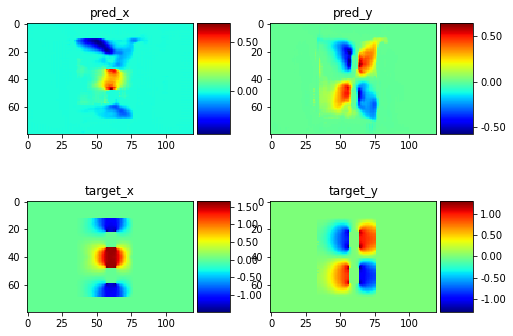

In [13]:
idx = 0
sample = val_set[idx]
pred = model(torch.tensor(sample[0]).float().unsqueeze(0)).detach()

fig, axes = plt.subplots(2,2,figsize=(8,6))

for i, name, image in zip(range(4),["pred_x","pred_y","target_x","target_y"], [pred[0,0,:,:],pred[0,1,:,:],sample[1][0,:,:],sample[1][1,:,:]]):
    im = axes[i//2,i%2].imshow(image.T, cmap='jet',interpolation='none')
    axes[i//2,i%2].set_title(name)

    divider = make_axes_locatable(axes[i//2,i%2])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, ticks=MultipleLocator(0.5), format="%.2f")